In [1]:
# Instalamos open cv en caso no se cuente con el
!pip install opencv-python

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# Se importan las librerías que utilizaremos
import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import numpy as np
import math

## Datos de transformación

In [3]:
# Se importa la información de los caminantes
headers = ['Number','Frame','headValid','bodyValid','headLeft','headTop','headRight','headBottom','bodyLeft','bodyTop','bodyRight','bodyBottom']
df = pd.read_csv('../Data/walkers.txt',sep=',',names=headers)
df.head()

,Number,Frame,headValid,bodyValid,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,0,1,1,270.828,794.098,309.037,834.066,235.925,770.142,371.546,1101.029
1,1,0,1,1,308.304,302.982,330.837,326.823,285.748,291.418,370.556,493.414
2,2,0,1,1,307.919,241.003,328.645,262.841,286.849,230.501,365.794,416.410
3,3,0,1,1,739.951,231.693,759.968,253.491,719.708,220.830,786.893,408.145
4,4,0,1,1,814.375,246.562,835.021,268.946,793.722,235.410,861.430,427.627


In [4]:
T_Matrix = [[ 1.43809441e+00 , 7.58290450e+00  ,7.93117275e+02],
             [-6.80696958e-01 , 8.22103159e+00  ,1.35956100e+03],
             [-7.73887614e-06  ,1.76518761e-03  ,1.00000000e+00]]
#6 lozas de ancho - Aproximamos ancho de 40 cm
#15 Lozas de alto - Aproximamos largo de 40 cm
pix_unit = 1.7 #pixeles por centimetro
width_street = 240*pix_unit
height_street = 600*pix_unit
width_img = 5000
height_img = 3500
#Dimensiones de la imagen final
final_size=(width_img,height_img)

## Determinacion de puntos infractores

In [5]:
def TransformPoints(in_points,T_Matrix):
    #Aplicacion de la transformación
    if in_points !=[]:
        puntos_np = np.array([in_points], dtype=np.float32)
        out_points = cv2.perspectiveTransform(puntos_np,np.array(T_Matrix))
    else:
        return []
    return out_points[0]

In [6]:
def PolicyPoints(in_points,window_points,threshold):
    #Determina puntos buenos y malos
    buenos = []
    malos = []
    window_buenos = []
    window_malos = []
    i = 0
    for point in in_points:
        es_malo = False
        for point2 in in_points:
            distance = math.sqrt((point[0]-point2[0])*(point[0]-point2[0])+(point[1]-point2[1])*(point[1]-point2[1]))
            if 0<distance < (threshold*pix_unit):
                es_malo = True
                break
        if es_malo ==False:
            buenos.append(point)
            window_buenos.append(window_points[i])
            i = i + 1
        else:
            malos.append(point)
            window_malos.append(window_points[i])
            i = i + 1
    return window_buenos,window_malos,buenos,malos

In [7]:
def ViewTransformPoints(buenos, malos,height_img,width_img):
    blank_image = np.zeros((height_img,width_img ,3), np.uint8)
    # se dibujan los puntos en la imagen de ojo de halcon
    for point in buenos:
        cv2.circle(blank_image,tuple(point), 30, (0,255,0), -1)
    for point in malos:
        cv2.circle(blank_image,tuple(point), 30, (0,0,255), -1)
    b,g,r = cv2.split(blank_image)
    frame_rgb = cv2.merge((r,g,b))
    frame_rgb= frame_rgb[0:3500,2000:4200]
    return frame_rgb

In [8]:
# Funcion para mostrar 40 frames de video junto con las ventanas para la deteccion de personas y caras
def Head_points(path): 
    vidObj = cv2.VideoCapture(path) 
    count = 0
    success = 1
    while success and count<40: 
        success, image = vidObj.read() 
        filter_df = df[df['Frame']==(count+1)]
        # Se obtienen los puntos que corresponden a las cabezas
        head_points = []
        window_points = []
        for index,row in filter_df.iterrows():
            start_point = (int(float(row['headLeft'])), int(float(row['headTop'])) )
            end_point = (int(float(row['headRight'])), int(float(row['headBottom'])))
            start_point2 = (int(float(row['bodyLeft'])), int(float(row['bodyTop'])) )
            end_point2 = (int(float(row['bodyRight'])), int(float(row['bodyBottom']))) 
            window_points.append([start_point,end_point,start_point2,end_point2])
            head_point = (int(start_point[0]/2+end_point[0]/2),int(start_point[1]/2+end_point[1]/2))
            head_points.append(head_point)
        head_transform_points=TransformPoints(np.array(head_points),T_Matrix)
        w_buenos,w_malos,buenos, malos = PolicyPoints(head_transform_points,window_points,200)
        for ventana in w_buenos:
            thickness = 2
            image = cv2.rectangle(image, ventana[0], ventana[1], (0,255,0), thickness) 
            image = cv2.rectangle(image, ventana[2], ventana[3], (0,255,0), thickness) 
        for ventana in w_malos:
            thickness = 2
            image = cv2.rectangle(image, ventana[0], ventana[1], (0,0,255), thickness) 
            image = cv2.rectangle(image, ventana[2], ventana[3], (0,0,255), thickness)    
            
        falcon_image=ViewTransformPoints(buenos,malos,height_img,width_img)
        plt.figure(figsize = (20,8))
        plt.subplot(121)
        plt.title('Original') 
        b,g,r = cv2.split(image)
        frame_rgb = cv2.merge((r,g,b))
        plt.imshow(frame_rgb)
        plt.subplot(122)
        plt.imshow(falcon_image)
        plt.title('Ojo de halcon') 
        plt.show()
        clear_output(wait=True)
        count += 1

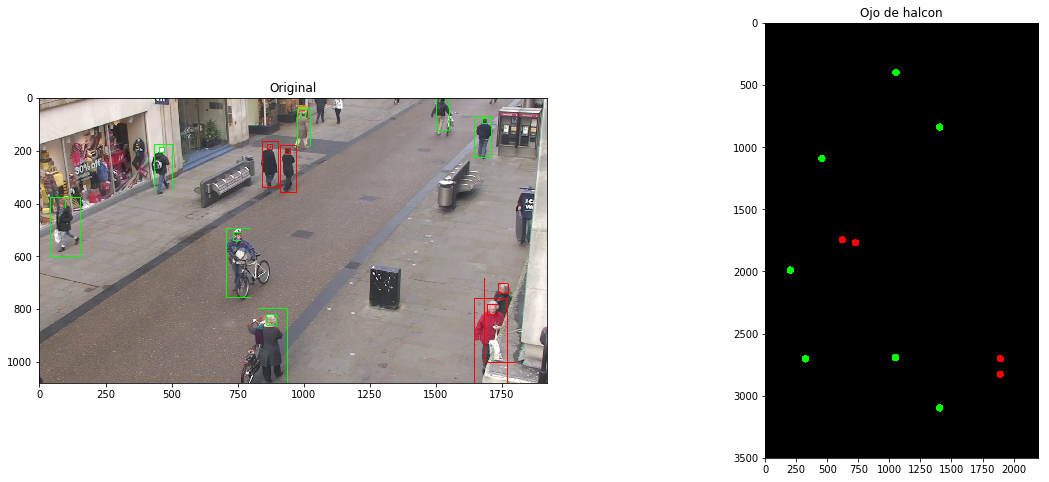

In [9]:
# Se aplica la funcion para visualizar 3 frames del video
head_points_frame = Head_points('../Data/calle.avi')

### Conclusión:
- Se filtra los puntos por distancia dada en cm
- El nuevo dataset de ventanas sirve mejor para el proyecto